In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from itertools import chain 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model

import pingouin as pg

In [165]:
def test_cv(learner, X, y, k=5):
    N = len(y)
    first = N % k
    first_n = int(N / k) + 1
    n = int(N / k)

    # print(N, first, first_n, n)

    shape = X.shape
    shuffle = np.zeros((shape[0], shape[1] + 1))
    shuffle[:, :-1] = X
    shuffle[:, -1] = y

    # np.random.shuffle(shuffle)
    per = np.random.permutation(N)

    pred = np.zeros([N, 1])

    for i in range(0, k):
        if i < first:
            from_i = i * first_n
            to_i = (i + 1) * first_n
            # print(i * first_n, (i + 1) * first_n)
        else:
            from_i = (first * first_n) + (i - first) * n
            to_i = (first * first_n) + (i - first + 1) * n
            # print((first * first_n) + (i - first) * n, (first * first_n) + (i - first + 1) * n)

        Xi_train = np.delete(shuffle, np.s_[per[from_i:to_i]], 0)
        Xi_test = shuffle[per[from_i:to_i]]

        c = learner.fit(Xi_train[:, :-1], Xi_train[:, -1])
        
        pred[per[from_i:to_i]] = np.array(c.predict(Xi_test[:, :-1])).reshape(len(pred[per[from_i:to_i]]), 1)
        RRMSE_max_hr = 1 - r2_score(y[per[from_i:to_i]], pred[per[from_i:to_i]])
        # print(RRMSE_max_hr)

    return pred

### Import data

In [7]:
df = pd.read_csv("data/all_normalized.csv")
df.head()

X_all = df.drop(['max_hr', 'vo2_l_min', 'vo2_ml_kg_min', 'Unnamed: 0'], axis=1)
y_hr = df['max_hr']
y_vo2 = df['vo2_ml_kg_min']

In [11]:
X_all.head()

,Smoked,PhysInactive,Aritmia,ageattest,height inch->cm,weight Ib->kg,BMI,waist,bodyfat,AnyMeds AN do AY,...,test_termination_reason_2.0,test_termination_reason_3.0,test_termination_reason_4.0,test_termination_reason_5.0,test_termination_reason_6.0,test_termination_reason_7.0,test_termination_reason_8.0,TestIndication_2.0,TestIndication_3.0,TestIndication_4.0
0,0.0,1.0,0.0,0.322812,0.666821,0.268406,0.218599,0.333921,0.150895,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.509326,0.254439,0.291403,0.455874,0.385551,0.300159,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.609756,0.208275,0.216546,0.393582,0.385551,0.537049,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.236729,0.450980,0.183053,0.227900,0.385551,0.300159,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.552367,0.647059,0.237614,0.198994,0.409780,0.259484,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## vo2_ml_kg_min

BMI                       --> 0.049899 //

ve_btbs                   --> 0.051857 //

weight Ib->kg             --> 0.053830

resting_dbp               --> 0.054944

peak_sbp                  --> 0.056452 //

resting_sbp               --> 0.062129

height inch->cm           --> 0.065005

resting_hr                --> 0.067020

ageattest                 --> 0.081574

max_rer                   --> 0.097260 //


In [10]:
X_vo2_relative = ['ageattest', 'resting_hr', 'height inch->cm',
           'resting_sbp', 'resting_dbp', 'weight Ib->kg']

## vo2_l_min

BMI                       --> 0.050817 //

resting_dbp               --> 0.051959 

ve_btbs                   --> 0.052530 //

weight Ib->kg             --> 0.053550

peak_sbp                  --> 0.056074 //

resting_sbp               --> 0.056182

height inch->cm           --> 0.066131

resting_hr                --> 0.066793

ageattest                 --> 0.079391 

max_rer                   --> 0.095180 //


In [5]:
X_vo2_absolute = ['ageattest', 'resting_hr', 'height inch->cm',
           'resting_sbp', 'resting_dbp', 'weight Ib->kg']

## hr_max top 10 features

BMI                       --> 0.052423 //

ve_btbs                   --> 0.053262 //

resting_dbp               --> 0.055141

weight Ib->kg             --> 0.055683

peak_sbp                  --> 0.056179 //

resting_sbp               --> 0.061111

resting_hr                --> 0.066919

height inch->cm           --> 0.068099

ageattest                 --> 0.079759

max_rer                   --> 0.094420 //


In [13]:
X_hr = ['ageattest', 'resting_hr', 'height inch->cm',
           'resting_sbp', 'resting_dbp', 'weight Ib->kg']

In [14]:
def powerset(seq):
    """
    Returns all the subsets of this set. This is a generator.
    """
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

## MODELS

### Lasso

In [184]:
comb = powerset(X_hr)
# X.head()

#
#
#

In [185]:
next_comb = next(comb)

best = 1
best_comb = next_comb

while(next_comb != []):
    # print(index, next_comb)
    
    clf = Lasso(alpha=0.1)

    res_lasso = test_cv(clf, X_all[next_comb], y_hr, k=10)
    RRMSE_max_hr = 1 - r2_score(y_hr, res_lasso)
    print("------------------------------")
    print("OVERALL RRMSE")
    print(RRMSE_max_hr)
    print("OVERALL RMSE")
    print(math.sqrt(mean_squared_error(y_hr, res_lasso)))
    
    if (RRMSE_max_hr < best):
        best = RRMSE_max_hr
        best_comb = next_comb
        print("Current best:", best, best_comb)
    
    next_comb = next(comb)
    index += 1

------------------------------
OVERALL RRMSE
0.7745148122661862
OVERALL RMSE
17.93116412213418
Current best: 0.7745148122661862 ['ageattest', 'resting_hr', 'height inch->cm', 'resting_sbp', 'resting_dbp', 'weight Ib->kg']
------------------------------
OVERALL RRMSE
0.9347745124434707
OVERALL RMSE
19.69913030204368
------------------------------
OVERALL RRMSE
0.7745830335911578
OVERALL RMSE
17.931953817062478
------------------------------
OVERALL RRMSE
0.935515585308078
OVERALL RMSE
19.706937317809654
------------------------------
OVERALL RRMSE
0.7803677943541223
OVERALL RMSE
17.99878920112453
------------------------------
OVERALL RRMSE
0.9360034023554351
OVERALL RMSE
19.71207465985268
------------------------------
OVERALL RRMSE
0.7803125810136378
OVERALL RMSE
17.998152455949764
------------------------------
OVERALL RRMSE
0.937006492830895
OVERALL RMSE
19.72263429007359
------------------------------
OVERALL RRMSE
0.7745983293237355
OVERALL RMSE
17.932130867813804
----------------

In [186]:
best

0.7745148122661862

In [187]:
best_comb

['ageattest',
 'resting_hr',
 'height inch->cm',
 'resting_sbp',
 'resting_dbp',
 'weight Ib->kg']

------------------------------
OVERALL RRMSE
0.7744851246091897
OVERALL RMSE
17.930820462243595


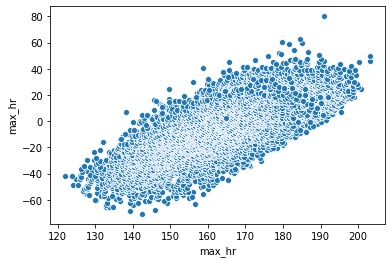

In [188]:
clf = Lasso(alpha=0.1)

res_lasso = test_cv(clf, X_all[best_comb], y_hr, k=10)
RRMSE_max_hr = 1 - r2_score(y_hr, res_lasso)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_hr, res_lasso)))

y_res = list(chain.from_iterable(res_lasso))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y_hr + y_res) / 2), y=(y_hr - y_res))

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X_all[best_comb], y_hr, test_size=0.3, random_state=420)
reg = clf.fit(X_train, y_train)
reg.coef_

fs = {X_all[best_comb].columns[reg.coef_ != 0][i]: reg.coef_[reg.coef_ != 0][i] for i in range(len(X_all[best_comb].columns[reg.coef_ != 0]))}
fs = {k: v for k, v in sorted(fs.items(), key=lambda item: item[1])}

pd.DataFrame.from_dict(fs, orient='index', columns=['weights'])

,weights
ageattest,-42.667489
weight Ib->kg,-24.474046
height inch->cm,-11.170373
resting_dbp,2.137836


In [193]:
y_pred = reg.predict(X_test)
RRMSE_max_hr = 1 - r2_score(y_test, y_pred)
print(RRMSE_max_hr)

0.7722430781341469


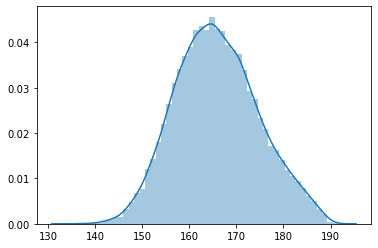

In [200]:
sns.distplot(y_res, bins= 50)

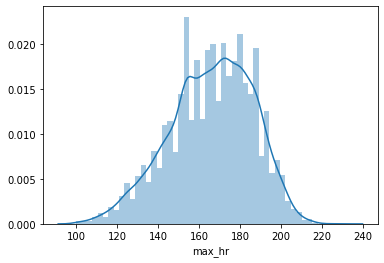

In [202]:
sns.distplot(y_hr, bins= 50)

In [204]:
pg.corr(y_res, y_hr) # change is significant, recet null hypostesis is favor of alternative (they are correlated)!

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,21432,0.476993,"[0.47, 0.49]",0.227522,0.22745,0.0,inf,1.0


### Random Forests

In [208]:
comb = powerset(X_hr)

In [210]:
next_comb = next(comb)

best = 1
best_comb = next_comb

while(next_comb != []):
    regr = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=0)
    res_rf = test_cv(regr, X_all[next_comb], y_hr, k=10)
    RRMSE_max_hr = 1 - r2_score(y_hr, res_rf)
    print("------------------------------")
    print("OVERALL RRMSE")
    print(RRMSE_max_hr)
    print("OVERALL RMSE")
    print(math.sqrt(mean_squared_error(y_hr, res_rf)))
    
    if (RRMSE_max_hr < best):
        best = RRMSE_max_hr
        best_comb = next_comb
        print("Current best:", best, best_comb)
    
    next_comb = next(comb)
    index += 1

------------------------------
OVERALL RRMSE
0.7618537785077713
OVERALL RMSE
17.78399938214103
Current best: 0.7618537785077713 ['resting_hr', 'height inch->cm', 'resting_sbp', 'resting_dbp', 'weight Ib->kg']
------------------------------
OVERALL RRMSE
0.6230065557091203
OVERALL RMSE
16.081995268481197
Current best: 0.6230065557091203 ['ageattest', 'height inch->cm', 'resting_sbp', 'resting_dbp', 'weight Ib->kg']
------------------------------
OVERALL RRMSE
0.7800076908117608
OVERALL RMSE
17.994635918730907
------------------------------
OVERALL RRMSE
0.6234868758296106
OVERALL RMSE
16.08819345176277
------------------------------
OVERALL RRMSE
0.7899351486472544
OVERALL RMSE
18.108786184144332
------------------------------
OVERALL RRMSE
0.6406762441117705
OVERALL RMSE
16.308459225967606
------------------------------
OVERALL RRMSE
0.8114983839586316
OVERALL RMSE
18.35428416820698
------------------------------
OVERALL RRMSE
0.6045911230176623
OVERALL RMSE
15.842528783385392
Current 

In [211]:
print(best)
print(best_comb)

0.6021388900889441
['ageattest', 'resting_hr', 'height inch->cm', 'resting_sbp', 'weight Ib->kg']


------------------------------
OVERALL RRMSE
0.603920222279635
OVERALL RMSE
15.833736300243789


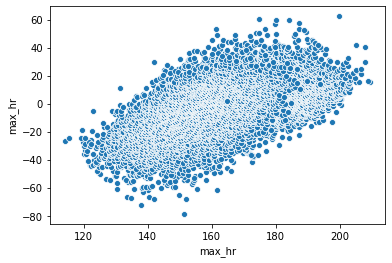

In [214]:
regr = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=0)
res_rf = test_cv(regr, X_all[best_comb], y_hr, k=10)
RRMSE_max_hr = 1 - r2_score(y_hr, res_rf)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_hr, res_rf)))

y_res = list(chain.from_iterable(res_rf))

sns.scatterplot(x=((y_hr + y_res) / 2), y=(y_hr - y_res))

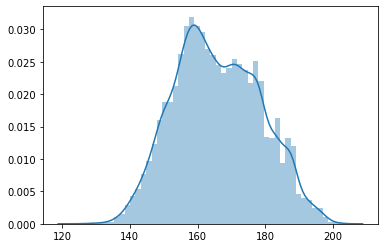

In [220]:
sns.distplot(y_res, bins= 50)

In [221]:
pg.corr(y_res, y_hr) # change is significant, recet null hypostesis is favor of alternative (they are correlated)!

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,21432,0.629985,"[0.62, 0.64]",0.396881,0.396825,0.0,inf,1.0


------------------------------
OVERALL RRMSE
0.6032024920543984
OVERALL RMSE
15.824324684929197


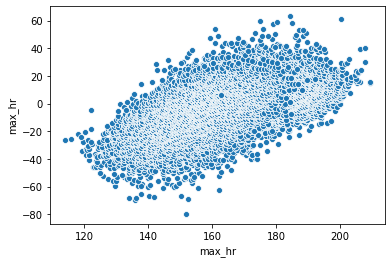

In [219]:
regr = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=0)
res_rf = test_cv(regr, X_all[['ageattest', 'resting_hr', 'height inch->cm', 'resting_sbp', 'weight Ib->kg', 'resting_dbp']], y_hr, k=10)
RRMSE_max_hr = 1 - r2_score(y_hr, res_rf)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_hr, res_rf)))

y_res = list(chain.from_iterable(res_rf))

sns.scatterplot(x=((y_hr + y_res) / 2), y=(y_hr - y_res))

### Neural Networks

In [246]:
X = X_all[X_hr]

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_hr), test_size=0.25, random_state=69)

X.head()

,ageattest,resting_hr,height inch->cm,resting_sbp,resting_dbp,weight Ib->kg
0,0.322812,0.318182,0.666821,0.381818,0.525000,0.268406
1,0.509326,0.456250,0.254439,0.380273,0.484375,0.291403
2,0.609756,0.456250,0.208275,0.380273,0.484375,0.216546
3,0.236729,0.704545,0.450980,0.380273,0.484375,0.183053
4,0.552367,0.409091,0.647059,0.345455,0.425000,0.237614


Hyperparameters:
units_1: 6
dropout_1: 0.4
units_2: 9
dropout_2: 0.05
learning_rate: 0.01
Score: 662.4161987304688

Hyperparameters:
units_1: 11
dropout_1: 0.35000000000000003
units_2: 4
dropout_2: 0.2
learning_rate: 0.01
Score: 1696.7288818359375

Hyperparameters:
units_1: 9
dropout_1: 0.1
units_2: 6
dropout_2: 0.4
learning_rate: 0.01
Score: 2654.97451171875

In [270]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# input layer
model.add(Dense(6,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.3))

# hidden layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(1))

# compile model
model.compile(optimizer='adam',loss='mse')

In [271]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=64,
          validation_data=(X_test, y_test), 
          )

Epoch 1/2000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

252/252 [==============================] - 0s 1ms/step - loss: 27231.3828 - val_loss: 24745.7969
Epoch 2/2000
252/252 [==============================] - 0s 832us/step - loss: 13479.4463 - val_loss: 2116.1008
Epoch 3/2000
252/252 [==============================] - 0s 829us/step - loss: 5283.1104 - val_loss: 1721.8402
Epoch 4/2000
252/252 [==============================] - 0s 881us/step - loss: 4748.5049 - val_loss: 1449.8389
Epoch 5/2000
252/252 [==============================] - 0s 838us/st

252/252 [==============================] - 0s 789us/step - loss: 942.9983 - val_loss: 625.9211
Epoch 70/2000
252/252 [==============================] - 0s 739us/step - loss: 958.0382 - val_loss: 584.8810
Epoch 71/2000
252/252 [==============================] - 0s 799us/step - loss: 945.8990 - val_loss: 605.5054
Epoch 72/2000
252/252 [==============================] - 0s 862us/step - loss: 948.7258 - val_loss: 569.2258
Epoch 73/2000
252/252 [==============================] - 0s 843us/step - loss: 958.5460 - val_loss: 562.0018
Epoch 74/2000
252/252 [==============================] - 0s 801us/step - loss: 943.6927 - val_loss: 585.5376
Epoch 75/2000
252/252 [==============================] - 0s 805us/step - loss: 956.6520 - val_loss: 579.7631
Epoch 76/2000
252/252 [==============================] - 0s 804us/step - loss: 935.8886 - val_loss: 570.5930
Epoch 77/2000
252/252 [==============================] - 0s 752us/step - loss: 929.4548 - val_loss: 580.1686
Epoch 78/2000
252/252 [==========

Epoch 144/2000
252/252 [==============================] - 0s 916us/step - loss: 841.0307 - val_loss: 488.5446
Epoch 145/2000
252/252 [==============================] - 0s 918us/step - loss: 836.4816 - val_loss: 488.1801
Epoch 146/2000
252/252 [==============================] - 0s 804us/step - loss: 825.3646 - val_loss: 480.6587
Epoch 147/2000
252/252 [==============================] - 0s 819us/step - loss: 847.3697 - val_loss: 478.1534
Epoch 148/2000
252/252 [==============================] - 0s 847us/step - loss: 834.5468 - val_loss: 492.7616
Epoch 149/2000
252/252 [==============================] - 0s 809us/step - loss: 830.2487 - val_loss: 488.5743
Epoch 150/2000
252/252 [==============================] - 0s 874us/step - loss: 826.7054 - val_loss: 483.5309
Epoch 151/2000
252/252 [==============================] - 0s 820us/step - loss: 841.3791 - val_loss: 478.6178
Epoch 152/2000
252/252 [==============================] - 0s 856us/step - loss: 843.2809 - val_loss: 497.3713
Epoch 153/

252/252 [==============================] - 0s 850us/step - loss: 743.7207 - val_loss: 441.9208
Epoch 219/2000
252/252 [==============================] - 0s 988us/step - loss: 737.5679 - val_loss: 457.8695
Epoch 220/2000
252/252 [==============================] - 0s 828us/step - loss: 745.3607 - val_loss: 456.8740
Epoch 221/2000
252/252 [==============================] - 0s 802us/step - loss: 754.4161 - val_loss: 446.5714
Epoch 222/2000
252/252 [==============================] - 0s 828us/step - loss: 746.3069 - val_loss: 432.2226
Epoch 223/2000
252/252 [==============================] - 0s 1ms/step - loss: 742.7018 - val_loss: 451.3530
Epoch 224/2000
252/252 [==============================] - 0s 944us/step - loss: 744.3160 - val_loss: 468.9240
Epoch 225/2000
252/252 [==============================] - 0s 787us/step - loss: 747.8647 - val_loss: 460.2657
Epoch 226/2000
252/252 [==============================] - 0s 784us/step - loss: 733.7657 - val_loss: 457.6113
Epoch 227/2000
252/252 [===

252/252 [==============================] - 0s 774us/step - loss: 665.8427 - val_loss: 452.2322
Epoch 293/2000
252/252 [==============================] - 0s 740us/step - loss: 667.4949 - val_loss: 432.8528
Epoch 294/2000
252/252 [==============================] - 0s 767us/step - loss: 669.2811 - val_loss: 412.8593
Epoch 295/2000
252/252 [==============================] - 0s 810us/step - loss: 669.4989 - val_loss: 428.4713
Epoch 296/2000
252/252 [==============================] - 0s 838us/step - loss: 667.1938 - val_loss: 420.0482
Epoch 297/2000
252/252 [==============================] - 0s 800us/step - loss: 662.9762 - val_loss: 424.6578
Epoch 298/2000
252/252 [==============================] - 0s 794us/step - loss: 672.4707 - val_loss: 439.7981
Epoch 299/2000
252/252 [==============================] - 0s 743us/step - loss: 671.1305 - val_loss: 424.5064
Epoch 300/2000
252/252 [==============================] - 0s 766us/step - loss: 670.0103 - val_loss: 412.5378
Epoch 301/2000
252/252 [=

252/252 [==============================] - 0s 791us/step - loss: 593.4084 - val_loss: 419.1111
Epoch 367/2000
252/252 [==============================] - 0s 781us/step - loss: 619.8144 - val_loss: 409.9069
Epoch 368/2000
252/252 [==============================] - 0s 800us/step - loss: 584.7856 - val_loss: 408.2172
Epoch 369/2000
252/252 [==============================] - 0s 830us/step - loss: 603.8709 - val_loss: 402.4283
Epoch 370/2000
252/252 [==============================] - 0s 889us/step - loss: 588.7343 - val_loss: 420.6251
Epoch 371/2000
252/252 [==============================] - 0s 831us/step - loss: 595.6450 - val_loss: 411.8236
Epoch 372/2000
252/252 [==============================] - 0s 811us/step - loss: 597.0156 - val_loss: 415.9867
Epoch 373/2000
252/252 [==============================] - 0s 884us/step - loss: 584.9114 - val_loss: 399.5521
Epoch 374/2000
252/252 [==============================] - 0s 784us/step - loss: 584.5508 - val_loss: 407.3636
Epoch 375/2000
252/252 [=

252/252 [==============================] - 0s 1ms/step - loss: 540.8857 - val_loss: 392.9744
Epoch 441/2000
252/252 [==============================] - 0s 780us/step - loss: 540.7689 - val_loss: 375.5172
Epoch 442/2000
252/252 [==============================] - 0s 855us/step - loss: 544.3245 - val_loss: 388.7409
Epoch 443/2000
252/252 [==============================] - 0s 827us/step - loss: 536.5681 - val_loss: 395.6996
Epoch 444/2000
252/252 [==============================] - 0s 799us/step - loss: 535.9326 - val_loss: 383.8572
Epoch 445/2000
252/252 [==============================] - 0s 772us/step - loss: 530.7021 - val_loss: 388.1927
Epoch 446/2000
252/252 [==============================] - 0s 851us/step - loss: 534.5209 - val_loss: 387.5907
Epoch 447/2000
252/252 [==============================] - 0s 831us/step - loss: 540.5663 - val_loss: 399.4153
Epoch 448/2000
252/252 [==============================] - 0s 779us/step - loss: 529.6375 - val_loss: 393.6844
Epoch 449/2000
252/252 [===

Epoch 515/2000
252/252 [==============================] - 0s 797us/step - loss: 490.2723 - val_loss: 361.4443
Epoch 516/2000
252/252 [==============================] - 0s 843us/step - loss: 487.6144 - val_loss: 379.9605
Epoch 517/2000
252/252 [==============================] - 0s 853us/step - loss: 489.3534 - val_loss: 379.3499
Epoch 518/2000
252/252 [==============================] - 0s 816us/step - loss: 487.9638 - val_loss: 363.6585
Epoch 519/2000
252/252 [==============================] - 0s 905us/step - loss: 491.1791 - val_loss: 383.8933
Epoch 520/2000
252/252 [==============================] - 0s 868us/step - loss: 490.7342 - val_loss: 385.5909
Epoch 521/2000
252/252 [==============================] - 0s 839us/step - loss: 492.9927 - val_loss: 376.1330
Epoch 522/2000
252/252 [==============================] - 0s 827us/step - loss: 476.6871 - val_loss: 369.7115
Epoch 523/2000
252/252 [==============================] - 0s 772us/step - loss: 482.5131 - val_loss: 370.5811
Epoch 524/

252/252 [==============================] - 0s 750us/step - loss: 449.7355 - val_loss: 357.8553
Epoch 590/2000
252/252 [==============================] - 0s 823us/step - loss: 453.2851 - val_loss: 372.4894
Epoch 591/2000
252/252 [==============================] - 0s 783us/step - loss: 451.2502 - val_loss: 373.8796
Epoch 592/2000
252/252 [==============================] - 0s 782us/step - loss: 446.9167 - val_loss: 367.6969
Epoch 593/2000
252/252 [==============================] - 0s 770us/step - loss: 449.7632 - val_loss: 374.9062
Epoch 594/2000
252/252 [==============================] - 0s 764us/step - loss: 443.0253 - val_loss: 370.6746
Epoch 595/2000
252/252 [==============================] - 0s 792us/step - loss: 452.5834 - val_loss: 359.1805
Epoch 596/2000
252/252 [==============================] - 0s 759us/step - loss: 445.6165 - val_loss: 361.8428
Epoch 597/2000
252/252 [==============================] - 0s 732us/step - loss: 440.6050 - val_loss: 363.7665
Epoch 598/2000
252/252 [=

252/252 [==============================] - 0s 1ms/step - loss: 415.1572 - val_loss: 354.4106
Epoch 665/2000
252/252 [==============================] - 0s 1ms/step - loss: 416.4015 - val_loss: 356.8592
Epoch 666/2000
252/252 [==============================] - 0s 1ms/step - loss: 423.4386 - val_loss: 357.9730
Epoch 667/2000
252/252 [==============================] - 0s 1ms/step - loss: 416.7912 - val_loss: 363.3392
Epoch 668/2000
252/252 [==============================] - 0s 1ms/step - loss: 418.1493 - val_loss: 350.9809
Epoch 669/2000
252/252 [==============================] - 0s 1ms/step - loss: 413.0077 - val_loss: 345.8837
Epoch 670/2000
252/252 [==============================] - 0s 1ms/step - loss: 419.1400 - val_loss: 358.1967
Epoch 671/2000
252/252 [==============================] - 0s 1ms/step - loss: 415.9810 - val_loss: 351.1896
Epoch 672/2000
252/252 [==============================] - 0s 1ms/step - loss: 416.0398 - val_loss: 347.4272
Epoch 673/2000
252/252 [===================

252/252 [==============================] - 0s 974us/step - loss: 396.9747 - val_loss: 349.6733
Epoch 740/2000
252/252 [==============================] - 0s 938us/step - loss: 389.2417 - val_loss: 343.9070
Epoch 741/2000
252/252 [==============================] - 0s 900us/step - loss: 389.1770 - val_loss: 355.0478
Epoch 742/2000
252/252 [==============================] - 0s 793us/step - loss: 393.7492 - val_loss: 352.0180
Epoch 743/2000
252/252 [==============================] - 0s 957us/step - loss: 395.3101 - val_loss: 344.2491
Epoch 744/2000
252/252 [==============================] - 0s 854us/step - loss: 389.7859 - val_loss: 346.8582
Epoch 745/2000
252/252 [==============================] - 0s 1ms/step - loss: 398.2661 - val_loss: 347.6463
Epoch 746/2000
252/252 [==============================] - 0s 907us/step - loss: 391.0393 - val_loss: 345.4448
Epoch 747/2000
252/252 [==============================] - 0s 925us/step - loss: 389.0969 - val_loss: 352.6046
Epoch 748/2000
252/252 [===

252/252 [==============================] - 0s 804us/step - loss: 378.2732 - val_loss: 341.9653
Epoch 814/2000
252/252 [==============================] - 0s 827us/step - loss: 371.1852 - val_loss: 341.0582
Epoch 815/2000
252/252 [==============================] - 0s 838us/step - loss: 372.3857 - val_loss: 339.0523
Epoch 816/2000
252/252 [==============================] - 0s 745us/step - loss: 371.5384 - val_loss: 342.1136
Epoch 817/2000
252/252 [==============================] - 0s 817us/step - loss: 373.3167 - val_loss: 343.7183
Epoch 818/2000
252/252 [==============================] - 0s 732us/step - loss: 370.3081 - val_loss: 339.4578
Epoch 819/2000
252/252 [==============================] - 0s 885us/step - loss: 373.5775 - val_loss: 339.8730
Epoch 820/2000
252/252 [==============================] - 0s 783us/step - loss: 371.5315 - val_loss: 331.6527
Epoch 821/2000
252/252 [==============================] - 0s 767us/step - loss: 373.6703 - val_loss: 342.0612
Epoch 822/2000
252/252 [=

252/252 [==============================] - 0s 840us/step - loss: 361.9712 - val_loss: 339.1432
Epoch 888/2000
252/252 [==============================] - 0s 861us/step - loss: 359.0473 - val_loss: 336.9970
Epoch 889/2000
252/252 [==============================] - 0s 802us/step - loss: 360.2513 - val_loss: 334.2203
Epoch 890/2000
252/252 [==============================] - 0s 749us/step - loss: 355.9903 - val_loss: 335.6715
Epoch 891/2000
252/252 [==============================] - 0s 815us/step - loss: 361.7762 - val_loss: 339.6360
Epoch 892/2000
252/252 [==============================] - 0s 883us/step - loss: 360.8748 - val_loss: 333.7023
Epoch 893/2000
252/252 [==============================] - 0s 795us/step - loss: 357.2007 - val_loss: 335.9685
Epoch 894/2000
252/252 [==============================] - 0s 963us/step - loss: 357.0099 - val_loss: 336.2430
Epoch 895/2000
252/252 [==============================] - 0s 765us/step - loss: 356.1748 - val_loss: 336.0823
Epoch 896/2000
252/252 [=

252/252 [==============================] - 0s 797us/step - loss: 345.9307 - val_loss: 335.5531
Epoch 963/2000
252/252 [==============================] - 0s 754us/step - loss: 348.0880 - val_loss: 331.3222
Epoch 964/2000
252/252 [==============================] - 0s 922us/step - loss: 351.6640 - val_loss: 334.2421
Epoch 965/2000
252/252 [==============================] - 0s 849us/step - loss: 348.9765 - val_loss: 332.5932
Epoch 966/2000
252/252 [==============================] - 0s 970us/step - loss: 350.3756 - val_loss: 328.1708
Epoch 967/2000
252/252 [==============================] - 0s 914us/step - loss: 347.8376 - val_loss: 327.7015
Epoch 968/2000
252/252 [==============================] - 0s 1ms/step - loss: 350.4181 - val_loss: 335.3038
Epoch 969/2000
252/252 [==============================] - 0s 974us/step - loss: 347.7846 - val_loss: 332.6133
Epoch 970/2000
252/252 [==============================] - 0s 934us/step - loss: 346.3579 - val_loss: 327.7707
Epoch 971/2000
252/252 [===

252/252 [==============================] - 0s 740us/step - loss: 340.0919 - val_loss: 325.9147
Epoch 1037/2000
252/252 [==============================] - 0s 807us/step - loss: 340.1929 - val_loss: 327.3448
Epoch 1038/2000
252/252 [==============================] - 0s 782us/step - loss: 342.9309 - val_loss: 327.1610
Epoch 1039/2000
252/252 [==============================] - 0s 734us/step - loss: 340.8361 - val_loss: 327.5421
Epoch 1040/2000
252/252 [==============================] - 0s 809us/step - loss: 342.4030 - val_loss: 325.8533
Epoch 1041/2000
252/252 [==============================] - 0s 753us/step - loss: 343.2199 - val_loss: 332.5580
Epoch 1042/2000
252/252 [==============================] - 0s 840us/step - loss: 342.8910 - val_loss: 331.3684
Epoch 1043/2000
252/252 [==============================] - 0s 821us/step - loss: 344.2103 - val_loss: 330.5396
Epoch 1044/2000
252/252 [==============================] - 0s 785us/step - loss: 343.4869 - val_loss: 331.9798
Epoch 1045/2000
2

Epoch 1110/2000
252/252 [==============================] - 0s 818us/step - loss: 337.9830 - val_loss: 324.3924
Epoch 1111/2000
252/252 [==============================] - 0s 859us/step - loss: 335.4998 - val_loss: 331.6096
Epoch 1112/2000
252/252 [==============================] - 0s 755us/step - loss: 337.4459 - val_loss: 326.2704
Epoch 1113/2000
252/252 [==============================] - 0s 822us/step - loss: 334.9349 - val_loss: 325.6476
Epoch 1114/2000
252/252 [==============================] - 0s 910us/step - loss: 336.7041 - val_loss: 322.4672
Epoch 1115/2000
252/252 [==============================] - 0s 964us/step - loss: 335.2957 - val_loss: 325.1281
Epoch 1116/2000
252/252 [==============================] - 0s 805us/step - loss: 335.6519 - val_loss: 321.8634
Epoch 1117/2000
252/252 [==============================] - 0s 764us/step - loss: 336.2711 - val_loss: 324.9773
Epoch 1118/2000
252/252 [==============================] - 0s 787us/step - loss: 334.4301 - val_loss: 322.9896
E

Epoch 1184/2000
252/252 [==============================] - 0s 744us/step - loss: 332.2522 - val_loss: 320.8333
Epoch 1185/2000
252/252 [==============================] - 0s 752us/step - loss: 333.6109 - val_loss: 328.3057
Epoch 1186/2000
252/252 [==============================] - 0s 768us/step - loss: 333.6438 - val_loss: 329.2968
Epoch 1187/2000
252/252 [==============================] - 0s 805us/step - loss: 333.2654 - val_loss: 323.6479
Epoch 1188/2000
252/252 [==============================] - 0s 773us/step - loss: 333.2842 - val_loss: 326.0593
Epoch 1189/2000
252/252 [==============================] - 0s 772us/step - loss: 331.3288 - val_loss: 325.6683
Epoch 1190/2000
252/252 [==============================] - 0s 809us/step - loss: 332.2253 - val_loss: 323.3724
Epoch 1191/2000
252/252 [==============================] - 0s 744us/step - loss: 334.8817 - val_loss: 323.6364
Epoch 1192/2000
252/252 [==============================] - 0s 792us/step - loss: 334.6788 - val_loss: 327.8560
E

252/252 [==============================] - 0s 1ms/step - loss: 332.5424 - val_loss: 321.8033
Epoch 1259/2000
252/252 [==============================] - 0s 1ms/step - loss: 329.1905 - val_loss: 319.6278
Epoch 1260/2000
252/252 [==============================] - 0s 1ms/step - loss: 331.1654 - val_loss: 324.7479
Epoch 1261/2000
252/252 [==============================] - 0s 975us/step - loss: 330.1290 - val_loss: 324.9066
Epoch 1262/2000
252/252 [==============================] - 0s 957us/step - loss: 333.8057 - val_loss: 318.8159
Epoch 1263/2000
252/252 [==============================] - 0s 1ms/step - loss: 329.8584 - val_loss: 322.9139
Epoch 1264/2000
252/252 [==============================] - 0s 1ms/step - loss: 331.6382 - val_loss: 322.1146
Epoch 1265/2000
252/252 [==============================] - 0s 991us/step - loss: 329.9944 - val_loss: 319.2884
Epoch 1266/2000
252/252 [==============================] - 0s 1ms/step - loss: 327.6197 - val_loss: 323.9648
Epoch 1267/2000
252/252 [====

252/252 [==============================] - 0s 914us/step - loss: 328.2063 - val_loss: 319.3999
Epoch 1333/2000
252/252 [==============================] - 0s 768us/step - loss: 328.1800 - val_loss: 323.6682
Epoch 1334/2000
252/252 [==============================] - 0s 974us/step - loss: 330.2977 - val_loss: 320.4694
Epoch 1335/2000
252/252 [==============================] - 0s 890us/step - loss: 327.8596 - val_loss: 320.2832
Epoch 1336/2000
252/252 [==============================] - 0s 939us/step - loss: 330.2785 - val_loss: 323.2773
Epoch 1337/2000
252/252 [==============================] - 0s 954us/step - loss: 328.4071 - val_loss: 327.2784
Epoch 1338/2000
252/252 [==============================] - 0s 989us/step - loss: 327.0334 - val_loss: 321.4715
Epoch 1339/2000
252/252 [==============================] - 0s 795us/step - loss: 328.9245 - val_loss: 324.4750
Epoch 1340/2000
252/252 [==============================] - 0s 846us/step - loss: 329.3733 - val_loss: 318.4689
Epoch 1341/2000
2

252/252 [==============================] - 0s 962us/step - loss: 330.3971 - val_loss: 329.5010
Epoch 1407/2000
252/252 [==============================] - 0s 746us/step - loss: 333.3338 - val_loss: 320.6611
Epoch 1408/2000
252/252 [==============================] - 0s 811us/step - loss: 331.5733 - val_loss: 321.3252
Epoch 1409/2000
252/252 [==============================] - 0s 806us/step - loss: 328.9537 - val_loss: 324.2018
Epoch 1410/2000
252/252 [==============================] - 0s 868us/step - loss: 327.4361 - val_loss: 321.1186
Epoch 1411/2000
252/252 [==============================] - 0s 773us/step - loss: 328.4846 - val_loss: 321.3867
Epoch 1412/2000
252/252 [==============================] - 0s 783us/step - loss: 327.5871 - val_loss: 323.1833
Epoch 1413/2000
252/252 [==============================] - 0s 859us/step - loss: 327.1311 - val_loss: 318.5399
Epoch 1414/2000
252/252 [==============================] - 0s 777us/step - loss: 329.9844 - val_loss: 321.0360
Epoch 1415/2000
2

Epoch 1480/2000
252/252 [==============================] - 0s 877us/step - loss: 330.5416 - val_loss: 323.1957
Epoch 1481/2000
252/252 [==============================] - 0s 798us/step - loss: 328.0187 - val_loss: 317.5491
Epoch 1482/2000
252/252 [==============================] - 0s 817us/step - loss: 329.2513 - val_loss: 322.9863
Epoch 1483/2000
252/252 [==============================] - 0s 854us/step - loss: 328.8481 - val_loss: 324.3014
Epoch 1484/2000
252/252 [==============================] - 0s 863us/step - loss: 327.7675 - val_loss: 319.9433
Epoch 1485/2000
252/252 [==============================] - 0s 828us/step - loss: 327.6125 - val_loss: 319.4635
Epoch 1486/2000
252/252 [==============================] - 0s 993us/step - loss: 328.4728 - val_loss: 321.4315
Epoch 1487/2000
252/252 [==============================] - 0s 1ms/step - loss: 327.3333 - val_loss: 319.6279
Epoch 1488/2000
252/252 [==============================] - 0s 847us/step - loss: 328.2400 - val_loss: 321.0625
Epo

Epoch 1554/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.7113 - val_loss: 319.7807
Epoch 1555/2000
252/252 [==============================] - 0s 1ms/step - loss: 327.5433 - val_loss: 322.3758
Epoch 1556/2000
252/252 [==============================] - 0s 980us/step - loss: 329.0148 - val_loss: 322.2550
Epoch 1557/2000
252/252 [==============================] - 0s 984us/step - loss: 326.4899 - val_loss: 319.2701
Epoch 1558/2000
252/252 [==============================] - 0s 986us/step - loss: 328.4573 - val_loss: 324.2335
Epoch 1559/2000
252/252 [==============================] - 0s 1ms/step - loss: 333.6298 - val_loss: 328.5135
Epoch 1560/2000
252/252 [==============================] - 0s 1ms/step - loss: 332.2407 - val_loss: 323.2705
Epoch 1561/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.6822 - val_loss: 320.2059
Epoch 1562/2000
252/252 [==============================] - 0s 1ms/step - loss: 326.1519 - val_loss: 323.0918
Epoch 1563/20

252/252 [==============================] - 0s 1ms/step - loss: 331.1111 - val_loss: 323.0747
Epoch 1629/2000
252/252 [==============================] - 0s 1ms/step - loss: 330.6970 - val_loss: 322.9706
Epoch 1630/2000
252/252 [==============================] - 0s 1ms/step - loss: 327.1697 - val_loss: 317.8873
Epoch 1631/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.9591 - val_loss: 316.1430
Epoch 1632/2000
252/252 [==============================] - 0s 1ms/step - loss: 329.2833 - val_loss: 322.0275
Epoch 1633/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.9127 - val_loss: 322.0798
Epoch 1634/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.6344 - val_loss: 324.6551
Epoch 1635/2000
252/252 [==============================] - 0s 1ms/step - loss: 326.8975 - val_loss: 319.1305
Epoch 1636/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.1176 - val_loss: 318.3359
Epoch 1637/2000
252/252 [==========

Epoch 1703/2000
252/252 [==============================] - 0s 1ms/step - loss: 326.6216 - val_loss: 323.5400
Epoch 1704/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.9893 - val_loss: 321.9057
Epoch 1705/2000
252/252 [==============================] - 0s 1ms/step - loss: 325.6123 - val_loss: 321.8298
Epoch 1706/2000
252/252 [==============================] - 0s 1ms/step - loss: 329.5306 - val_loss: 320.9308
Epoch 1707/2000
252/252 [==============================] - 0s 1ms/step - loss: 329.4708 - val_loss: 327.0274
Epoch 1708/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.3271 - val_loss: 320.4500
Epoch 1709/2000
252/252 [==============================] - 0s 989us/step - loss: 330.3706 - val_loss: 321.7562
Epoch 1710/2000
252/252 [==============================] - 0s 987us/step - loss: 329.4175 - val_loss: 322.6501
Epoch 1711/2000
252/252 [==============================] - 0s 982us/step - loss: 328.2344 - val_loss: 325.9433
Epoch 1712/20

252/252 [==============================] - 0s 787us/step - loss: 325.5308 - val_loss: 321.1140
Epoch 1778/2000
252/252 [==============================] - 0s 769us/step - loss: 328.1671 - val_loss: 318.8232
Epoch 1779/2000
252/252 [==============================] - 0s 749us/step - loss: 328.5056 - val_loss: 319.2854
Epoch 1780/2000
252/252 [==============================] - 0s 721us/step - loss: 327.1226 - val_loss: 319.9076
Epoch 1781/2000
252/252 [==============================] - 0s 802us/step - loss: 329.0775 - val_loss: 321.4943
Epoch 1782/2000
252/252 [==============================] - 0s 978us/step - loss: 329.9956 - val_loss: 318.5356
Epoch 1783/2000
252/252 [==============================] - 0s 996us/step - loss: 333.4777 - val_loss: 329.6747
Epoch 1784/2000
252/252 [==============================] - 0s 881us/step - loss: 330.7098 - val_loss: 318.6102
Epoch 1785/2000
252/252 [==============================] - 0s 1ms/step - loss: 328.3070 - val_loss: 321.7598
Epoch 1786/2000
252

Epoch 1851/2000
252/252 [==============================] - 0s 837us/step - loss: 328.3618 - val_loss: 320.2004
Epoch 1852/2000
252/252 [==============================] - 0s 794us/step - loss: 328.5391 - val_loss: 320.3454
Epoch 1853/2000
252/252 [==============================] - 0s 971us/step - loss: 328.9725 - val_loss: 320.9116
Epoch 1854/2000
252/252 [==============================] - 0s 838us/step - loss: 327.2011 - val_loss: 322.0083
Epoch 1855/2000
252/252 [==============================] - 0s 871us/step - loss: 328.7419 - val_loss: 321.3229
Epoch 1856/2000
252/252 [==============================] - 0s 814us/step - loss: 329.0715 - val_loss: 319.8650
Epoch 1857/2000
252/252 [==============================] - 0s 801us/step - loss: 326.6366 - val_loss: 320.6462
Epoch 1858/2000
252/252 [==============================] - 0s 787us/step - loss: 328.8089 - val_loss: 321.9346
Epoch 1859/2000
252/252 [==============================] - 0s 765us/step - loss: 329.3676 - val_loss: 319.5359
E

Epoch 1925/2000
252/252 [==============================] - 0s 745us/step - loss: 330.1200 - val_loss: 319.6281
Epoch 1926/2000
252/252 [==============================] - 0s 765us/step - loss: 330.4977 - val_loss: 320.8470
Epoch 1927/2000
252/252 [==============================] - 0s 821us/step - loss: 329.9930 - val_loss: 322.8173
Epoch 1928/2000
252/252 [==============================] - 0s 732us/step - loss: 330.5322 - val_loss: 318.0061
Epoch 1929/2000
252/252 [==============================] - 0s 812us/step - loss: 329.2967 - val_loss: 322.3695
Epoch 1930/2000
252/252 [==============================] - 0s 753us/step - loss: 325.9084 - val_loss: 320.8715
Epoch 1931/2000
252/252 [==============================] - 0s 738us/step - loss: 331.4261 - val_loss: 323.4152
Epoch 1932/2000
252/252 [==============================] - 0s 762us/step - loss: 330.0547 - val_loss: 320.8787
Epoch 1933/2000
252/252 [==============================] - 0s 771us/step - loss: 327.5021 - val_loss: 319.0004
E

Epoch 1999/2000
252/252 [==============================] - 0s 744us/step - loss: 330.1563 - val_loss: 324.1126
Epoch 2000/2000
252/252 [==============================] - 0s 737us/step - loss: 327.2283 - val_loss: 320.9382


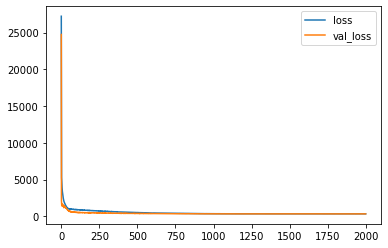

In [272]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

------------------------------
OVERALL RRMSE
0.7608667973429877
OVERALL RMSE
17.91474948226319


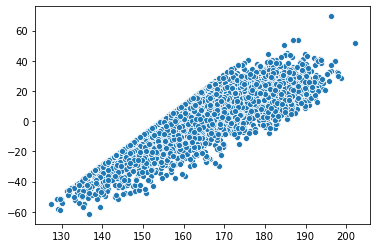

In [273]:
# X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_hr), test_size=0.25, random_state=15)

res_nn = model.predict(X_test)
RRMSE_max_hr = 1 - r2_score(y_test, res_nn)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_test, res_nn)))

y_res = list(chain.from_iterable(res_nn))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y_test + y_res) / 2), y=(y_test - y_res))

In [274]:
"""Hyperparameters:
dropout_0: 0.2
units_1: 6
dropout_1: 0.4
units_2: 9
dropout_2: 0.05
learning_rate: 0.01
Score: 0.81"""

'Hyperparameters:\ndropout_0: 0.2\nunits_1: 6\ndropout_1: 0.4\nunits_2: 9\ndropout_2: 0.05\nlearning_rate: 0.01\nScore: 0.81'

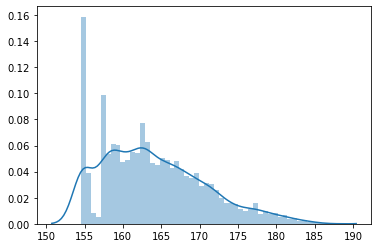

In [276]:
sns.distplot(y_res, bins= 50)

In [278]:
pg.corr(y_res, y_test) # change is significant, recet null hypostesis is favor of alternative (they are correlated)!

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,5358,0.546022,"[0.53, 0.56]",0.29814,0.297878,0.0,inf,1.0


### SVM

In [85]:
X = X_all[X_hr_10]

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_hr), test_size=0.25, random_state=69)

X.head()

,max_rer,ageattest,height inch->cm,resting_hr,resting_sbp,peak_sbp,weight Ib->kg,resting_dbp,ve_btbs,BMI
0,0.34,0.322812,0.666821,0.318182,0.381818,0.449891,0.268406,0.525000,1.000000,0.218599
1,0.22,0.509326,0.254439,0.456250,0.380273,0.456522,0.291403,0.484375,0.453992,0.455874
2,0.36,0.609756,0.208275,0.456250,0.380273,0.347826,0.216546,0.484375,0.457786,0.393582
3,0.16,0.236729,0.450980,0.704545,0.380273,0.449891,0.183053,0.484375,0.403765,0.227900
4,0.36,0.552367,0.647059,0.409091,0.345455,0.449891,0.237614,0.425000,0.352938,0.198994


In [86]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [87]:
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=3)

In [88]:
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.233, total=   5.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.237, total=   5.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.230, total=   5.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.213, total=   5.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.218, total=   5.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.102, total=   5.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.107, total=   6.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.103, total=   6.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.096, total=   6.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.228, total=   5.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.228, total=   5.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.223, total=   5.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.205, total=   6.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.215, total=   6.3s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.105, total=   6.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.109, total=   7.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.213, total=   5.9s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.237, total=   6.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.228, total=   5.9s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.227, total=   6.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.223, total=   6.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.204, total=   6.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.215, total=   6.2s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 14.2min finished


{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

In [223]:
# best = {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

In [229]:
comb = powerset(X_hr)

In [230]:
next_comb = next(comb)

best = 1
best_comb = next_comb

svr = SVR(C=1000.0, kernel='rbf', gamma=1.0)

while(next_comb != []):
    res_svm = test_cv(svr, X_all[next_comb], y_hr, k=10)
    RRMSE_max_hr = 1 - r2_score(y_hr, res_svm)
    print("------------------------------")
    print("OVERALL RRMSE")
    print(RRMSE_max_hr)
    print("OVERALL RMSE")
    print(math.sqrt(mean_squared_error(y_hr, res_svm)))
    
    if (RRMSE_max_hr < best):
        best = RRMSE_max_hr
        best_comb = next_comb
        print("Current best:", best, best_comb)
    
    next_comb = next(comb)
    index += 1

------------------------------
OVERALL RRMSE
0.7200489297311766
OVERALL RMSE
17.289189174711932
Current best: 0.7200489297311766 ['ageattest', 'resting_hr', 'height inch->cm', 'resting_sbp', 'resting_dbp', 'weight Ib->kg']
------------------------------
OVERALL RRMSE
0.877854648036409
OVERALL RMSE
19.089956033963052
------------------------------
OVERALL RRMSE
0.7308407495842713
OVERALL RMSE
17.418269222852437
------------------------------
OVERALL RRMSE
0.8865733878951668
OVERALL RMSE
19.18452130992625
------------------------------
OVERALL RRMSE
0.7301564056763529
OVERALL RMSE
17.410112262411534
------------------------------
OVERALL RRMSE
0.88718918208217
OVERALL RMSE
19.191182724643948
------------------------------
OVERALL RRMSE
0.7404613213903161
OVERALL RMSE
17.532538875512437
------------------------------
OVERALL RRMSE
0.8948518348244289
OVERALL RMSE
19.273881661067065
------------------------------
OVERALL RRMSE
0.7365665769158097
OVERALL RMSE
17.486368477121154
-------------

In [231]:
print(best)
print(best_comb)

0.7200489297311766
['ageattest', 'resting_hr', 'height inch->cm', 'resting_sbp', 'resting_dbp', 'weight Ib->kg']


------------------------------
OVERALL RRMSE
0.7198568454054052
OVERALL RMSE
17.286882939941506


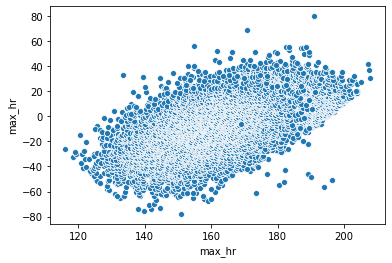

In [238]:
svr = SVR(C=1000.0, kernel='rbf', gamma=1.0)

res_svm = test_cv(svr, X_all[best_comb], y_hr, k=10)
RRMSE_max_hr = 1 - r2_score(y_hr, res_svm)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_hr, res_svm)))

y_res = list(chain.from_iterable(res_svm))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y_hr + y_res) / 2), y=(y_hr - y_res))

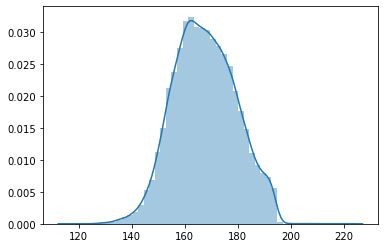

In [239]:
sns.distplot(y_res, bins= 50)

In [240]:
pg.corr(y_res, y_hr) # change is significant, recet null hypostesis is favor of alternative (they are correlated)!

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,21432,0.537326,"[0.53, 0.55]",0.288719,0.288652,0.0,inf,1.0
